<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "GC"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level2-MajorCellType/GC/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


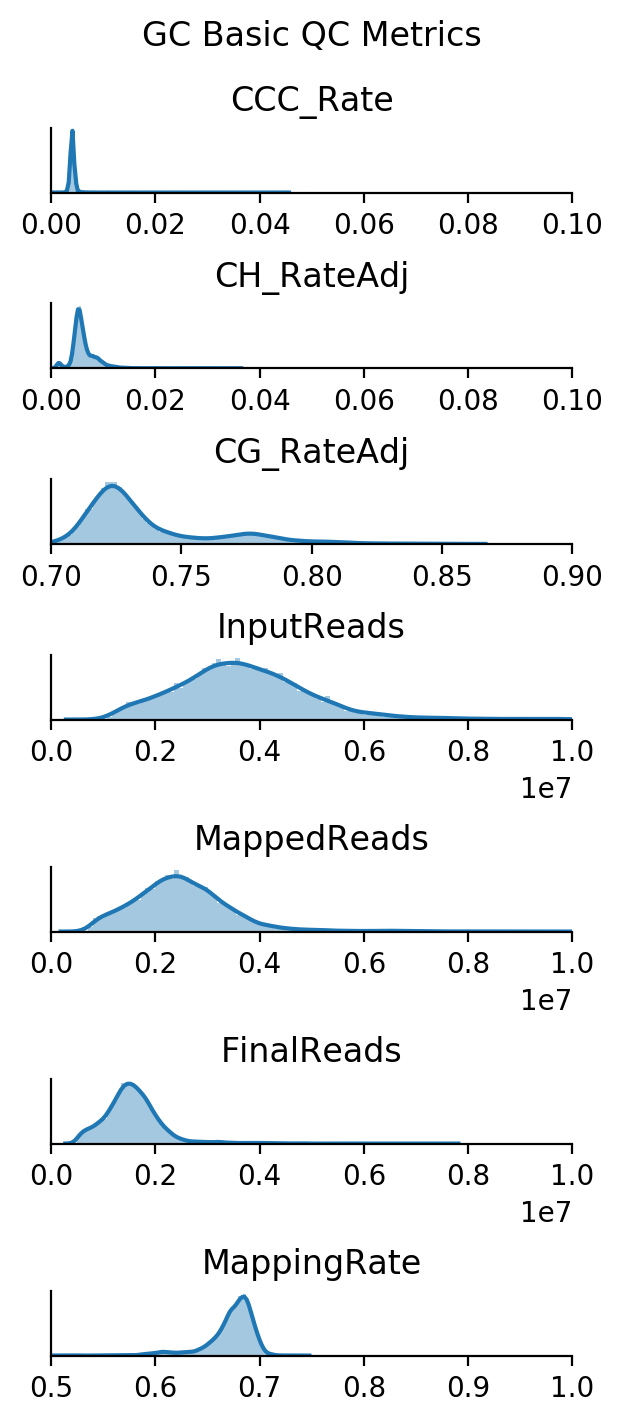

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

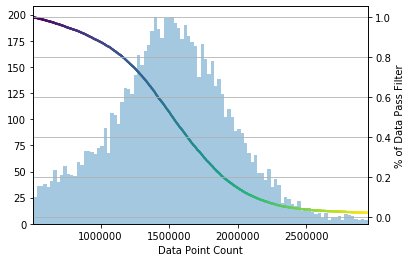

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 8224/8224 (100.0%)
CG_RateAdj passed 8224/8224 (100.0%)
CH_RateAdj passed 8224/8224 (100.0%)
FinalReads passed 8224/8224 (100.0%)
MappingRate passed 8224/8224 (100.0%)
Overall passed 8224/8224 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 5
171219 12
180109 8
180110 14
180111 5
180119 3
180129 1
180206 1
180208 616
180212 440
180213 2
180220 146
180222 121
180226 2
180227 1
180305 1
180313 7
180319 7
180329 1
180402 1
180403 122
180405 5
180417 1
180424 1
180430 1
180612 1
180806 1
180911 4
180917 6
180925 9
181008 1
181009 3
181015 4
181016 9
181204 17
181206 20
181210 4
181218 2
181220 1
190131 1
190205 3
190207 7
190212 1241
190214 1048
190219 999
190305 1178
190625 361
190627 132
190711 983
190716 665


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 983 256.0%
ad002 988 257.3%
ad004 1002 260.9%
ad006 1011 263.3%
ad007 1048 272.9%
ad008 1056 275.0%
ad010 1076 280.2%
ad012 1060 276.0%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,MappingRate,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_122,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.003843,0.725228,0.724167,0.005406,0.001569,1961192.0,4950216,3245770.0,10E,...,0.655682,B12,CEMBA190625-10E-2,11,1,23,2,190625,10,True
10E_M_1523,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003702,0.719537,0.718495,0.009076,0.005394,1676881.0,4605462,2941378.0,10E,...,0.638672,A11,CEMBA190627-10E-1,10,0,20,0,190627,10,True
10E_M_1563,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003893,0.721965,0.720879,0.009851,0.005982,3259811.0,10079200,6565439.0,10E,...,0.651385,A5,CEMBA190627-10E-1,4,0,8,1,190627,10,True
10E_M_1685,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003896,0.737562,0.736535,0.011256,0.007388,1800469.0,4943432,3285265.0,10E,...,0.664572,B9,CEMBA190627-10E-1,8,1,16,2,190627,10,True
10E_M_1778,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004139,0.769107,0.768148,0.013604,0.009504,1070711.0,3374684,2010267.0,10E,...,0.595690,C9,CEMBA190627-10E-1,8,2,16,4,190627,10,True
10E_M_2038,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004231,0.738506,0.737395,0.011528,0.007328,2321877.0,7251924,4737681.0,10E,...,0.653300,F7,CEMBA190627-10E-1,6,5,12,11,190627,10,True
10E_M_2080,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004238,0.740505,0.739401,0.011488,0.007281,1921931.0,5248422,3457149.0,10E,...,0.658703,G11,CEMBA190627-10E-2,10,6,20,12,190627,10,True
10E_M_2122,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004411,0.725945,0.724731,0.010758,0.006375,1902200.0,6281160,4145799.0,10E,...,0.660037,G5,CEMBA190627-10E-2,4,6,9,13,190627,10,True
10E_M_2353,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.004623,0.761472,0.760364,0.014147,0.009568,1989267.0,5466604,3550057.0,10E,...,0.649408,B11,CEMBA190627-10E-3,10,1,21,2,190627,10,True
